# Proyek Klasifikasi Gambar: [Vegetable Image Dataset]
- **Nama:** [Bagus Darmawan]
- **Email:** [bagusdarmawannnn@gmail.com]
- **ID Dicoding:** [Bagusdarmawan11]

> Proyek ini merupakan tugas akhir dari kelas "Belajar Pengembangan Machine Learning". Tujuan utama dari proyek ini adalah membangun model klasifikasi gambar berbasis CNN untuk mengklasifikasikan gambar sayuran menggunakan dataset kaggle dengan jumlah gambar > 1000.

## Import Semua Packages/Library yang Digunakan

Pada bagian ini, seluruh library yang dibutuhkan untuk pemrosesan data, pelatihan model, evaluasi, dan konversi model akan diimpor. Library tambahan seperti `tensorflowjs` juga diinstal untuk mendukung konversi model ke format TFJS.

In [66]:
# Instal library tambahan
!pip install tensorflowjs

# Import semua library utama
import os
import zipfile
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflowjs as tfjs

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image

## Data Preparation

Langkah pertama dalam membangun model klasifikasi gambar adalah mempersiapkan data. Dataset yang digunakan adalah dataset sayuran yang berisi gambar dari berbagai kelas sayuran. Dataset ini diunduh dari Kaggle, lalu seluruh gambar dari folder `Train`, `Validation`, dan `Test` akan digabung menjadi satu folder per kelas untuk kemudian dibagi ulang secara mandiri.

### Data Loading

Dataset akan diunduh menggunakan API Kaggle, lalu diekstrak. Pastikan API key Kaggle telah ditambahkan ke environment Google Colab sebelum menjalankan proses ini.

In [15]:
# Buat direktori untuk Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Download dan Ekstraksi Dataset

Dataset sayuran diunduh dari Kaggle dan diekstrak ke dalam folder `dataset/`. Pastikan file `kaggle.json` telah diunggah ke workspace sebelum menjalankan bagian ini.


In [4]:
# Download dataset
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0


In [5]:
# Ekstrak file ZIP
with zipfile.ZipFile('vegetable-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

## Data Preprocessing

Pada tahap ini, seluruh gambar dari direktori `train`, `test`, dan `validation` akan digabung terlebih dahulu ke dalam satu direktori per kelas agar dapat dilakukan pembagian ulang dataset (train/test/val) secara acak dan proporsional.


### Gabungkan Dataset

Untuk memenuhi kriteria pembagian dataset mandiri (tidak menggunakan struktur default dari dataset), seluruh gambar dari folder `Train`, `Validation`, dan `Test` akan digabung terlebih dahulu ke dalam satu folder per kelas. Hal ini dilakukan agar proses pembagian dataset bisa dilakukan ulang secara acak dan adil, dengan mempertimbangkan keseimbangan antar kelas.

In [6]:
# Set path folder dataset asli
base_dir = 'dataset/Vegetable Images'
train_folder = os.path.join(base_dir, 'train')
valid_folder = os.path.join(base_dir, 'validation')
test_folder  = os.path.join(base_dir, 'test')

In [7]:
# Folder baru untuk dataset gabungan
combined_dir = 'Dataset Sayuran'
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

In [8]:
# Gabungkan gambar dari train, test, validasi → ke dalam satu folder per kelas
for folder in [train_folder, valid_folder, test_folder]:
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        combined_class_path = os.path.join(combined_dir, class_name)
        os.makedirs(combined_class_path, exist_ok=True)

        for image_file in os.listdir(class_path):
            src = os.path.join(class_path, image_file)
            dst = os.path.join(combined_class_path, f"{class_name}_{image_file}")
            shutil.copyfile(src, dst)

print("✅ Semua gambar berhasil digabung ke dalam folder `Dataset Sayuran`.")

✅ Semua gambar berhasil digabung ke dalam folder `Dataset Sayuran`.


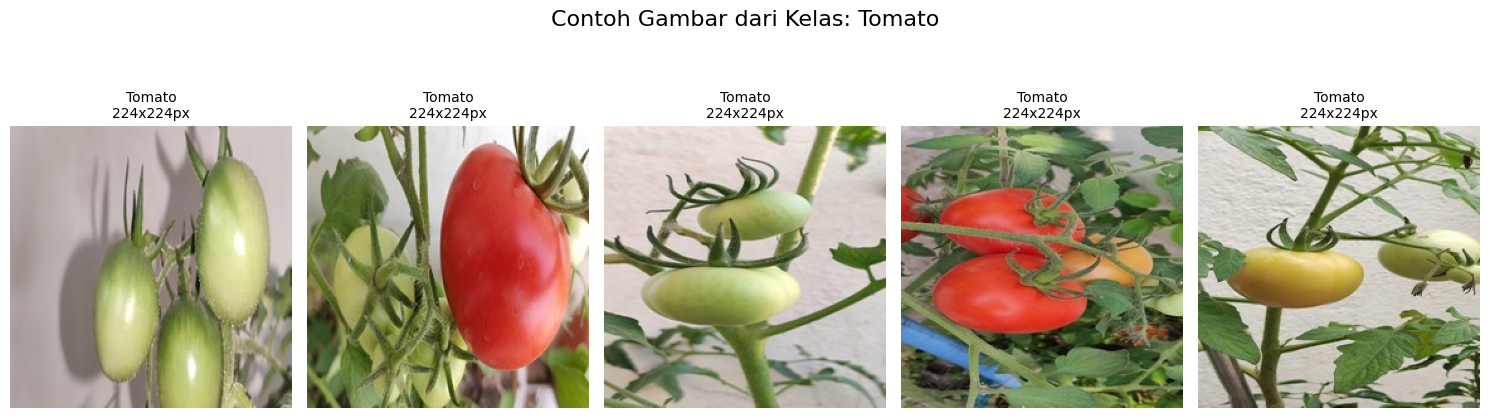

In [16]:
# Tampilkan 5 gambar pertama dari salah satu kelas, misalnya: Tomato
sample_class = 'Tomato'
sample_dir = os.path.join(train_dir, sample_class)
sample_images = os.listdir(sample_dir)[:5]

plt.figure(figsize=(15, 5))
for i, image_name in enumerate(sample_images):
    img_path = os.path.join(sample_dir, image_name)

    # Baca gambar dengan PIL untuk mendapatkan resolusi
    with Image.open(img_path) as pil_img:
        width, height = pil_img.size

    # Baca gambar untuk ditampilkan
    img = mpimg.imread(img_path)

    # Plot gambar dan resolusinya
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{sample_class}\n{width}x{height}px", fontsize=10)
    plt.axis('off')

plt.suptitle(f'Contoh Gambar dari Kelas: {sample_class}', fontsize=16)
plt.tight_layout()
plt.show()


#### Split Dataset
Dataset yang telah digabung akan dibagi secara mandiri ke dalam 3 set:
- **Training Set**: digunakan untuk melatih model
- **Validation Set**: digunakan untuk memantau performa model selama pelatihan
- **Test Set**: digunakan untuk mengevaluasi performa model secara final

Pembagian dilakukan secara acak dengan mempertahankan distribusi kelas (stratified split), menggunakan `train_test_split` dari `sklearn`. Rasio pembagian yang digunakan adalah:
- 80% training
- 10% validation
- 10% testing

In [17]:
# Folder akhir untuk dataset yang sudah dipisah
final_dir = 'split_dataset'
train_dir = os.path.join(final_dir, 'train')
val_dir   = os.path.join(final_dir, 'val')
test_dir  = os.path.join(final_dir, 'test')

In [18]:
# Bagi gambar setiap kelas menggunakan train_test_split (80% train, 10% val, 10% test)
for class_name in os.listdir(combined_dir):
    class_path = os.path.join(combined_dir, class_name)
    images = os.listdir(class_path)

    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for folder, img_list in zip([train_dir, val_dir, test_dir], [train_imgs, val_imgs, test_imgs]):
        class_folder = os.path.join(folder, class_name)
        os.makedirs(class_folder, exist_ok=True)

        for img in img_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(class_folder, img)
            shutil.copyfile(src, dst)

print("✅ Dataset berhasil dibagi menjadi train, val, dan test.")

✅ Dataset berhasil dibagi menjadi train, val, dan test.


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameter gambar
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32

# Augmentasi hanya untuk train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validasi & test tidak perlu augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data dari folder
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 16800 images belonging to 15 classes.
Found 2100 images belonging to 15 classes.
Found 2100 images belonging to 15 classes.


## Modelling

Model CNN dibangun menggunakan API `Sequential` dari Keras. Arsitektur terdiri dari beberapa lapisan Conv2D, MaxPooling, dan Dropout untuk mengurangi overfitting. Model ini dioptimasi menggunakan Adam dan fungsi loss categorical crossentropy, karena tugas klasifikasi ini bersifat multi-class.


In [22]:
# Jumlah kelas dari generator
num_classes = train_generator.num_classes

In [23]:
# Membangun model
model = Sequential([
    # Blok 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    # Blok 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Blok 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Blok 4 (opsional, memperdalam model agar lebih kuat)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten dan Fully Connected Layer
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Softmax untuk multi-kelas
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Ringkasan arsitektur
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,711 (3.99 MB)

 Trainable params: 1,045,711 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Buat direktori untuk menyimpan model terbaik
checkpoint_dir = 'best_model'
os.makedirs(checkpoint_dir, exist_ok=True)

In [28]:
# Callback untuk menghentikan training saat validasi tidak meningkat
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
# Callback untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [31]:
# Training model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4255 - loss: 1.6454

525/525 ━━━━━━━━━━━━━━━━━━━━ 932s 2s/step - accuracy: 0.4258 - loss: 1.6448 - val_accuracy: 0.7195 - val_loss: 0.8367
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7374 - loss: 0.7584

525/525 ━━━━━━━━━━━━━━━━━━━━ 931s 2s/step - accuracy: 0.7374 - loss: 0.7583 - val_accuracy: 0.8200 - val_loss: 0.5575
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 916s 2s/step - accuracy: 0.8289 - loss: 0.5082 - val_accuracy: 0.7867 - val_loss: 0.7031
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8792 - loss: 0.3563

525/525 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.8792 - loss: 0.3563 - val_accuracy: 0.9038 - val_loss: 0.3117
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9057 - loss: 0.2844

525/525 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.9057 - loss: 0.2843 - val_accuracy: 0.9214 - val_loss: 0.2593
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 915s 2s/step - accuracy: 0.9277 - loss: 0.2209 - val_accuracy: 0.8924 - val_loss: 0.3609
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9349 - loss: 0.2036

525/525 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.9349 - loss: 0.2036 - val_accuracy: 0.9390 - val_loss: 0.2059
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9485 - loss: 0.1568

525/525 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.9485 - loss: 0.1568 - val_accuracy: 0.9500 - val_loss: 0.1713
Epoch 9/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 925s 2s/step - accuracy: 0.9530 - loss: 0.1427 - val_accuracy: 0.9457 - val_loss: 0.1866
Epoch 10/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 916s 2s/step - accuracy: 0.9576 - loss: 0.1318 - val_accuracy: 0.9343 - val_loss: 0.2667
Epoch 11/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 927s 2s/step - accuracy: 0.9590 - loss: 0.1272 - val_accuracy: 0.9381 - val_loss: 0.2527
Epoch 12/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9555 - loss: 0.1360

525/525 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.9555 - loss: 0.1360 - val_accuracy: 0.9595 - val_loss: 0.1360
Epoch 13/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9642 - loss: 0.1127

525/525 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.9642 - loss: 0.1127 - val_accuracy: 0.9671 - val_loss: 0.1207
Epoch 14/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 916s 2s/step - accuracy: 0.9693 - loss: 0.0926 - val_accuracy: 0.9633 - val_loss: 0.1296
Epoch 15/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9605 - loss: 0.1272

525/525 ━━━━━━━━━━━━━━━━━━━━ 918s 2s/step - accuracy: 0.9606 - loss: 0.1271 - val_accuracy: 0.9690 - val_loss: 0.1066
Epoch 16/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.9745 - loss: 0.0826 - val_accuracy: 0.8886 - val_loss: 0.4000
Epoch 17/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9731 - loss: 0.0806

525/525 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.9731 - loss: 0.0806 - val_accuracy: 0.9776 - val_loss: 0.1006
Epoch 18/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.9693 - loss: 0.0948 - val_accuracy: 0.9638 - val_loss: 0.1284
Epoch 19/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 916s 2s/step - accuracy: 0.9734 - loss: 0.0871 - val_accuracy: 0.9624 - val_loss: 0.1458
Epoch 20/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 916s 2s/step - accuracy: 0.9715 - loss: 0.0950 - val_accuracy: 0.9705 - val_loss: 0.1113
Epoch 21/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.9758 - loss: 0.0839 - val_accuracy: 0.9752 - val_loss: 0.0888
Epoch 22/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 922s 2s/step - accuracy: 0.9756 - loss: 0.0712 - val_accuracy: 0.9714 - val_loss: 0.1109
Epoch 23/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 977s 2s/step - accuracy: 0.9788 - loss: 0.0703 - val_accuracy: 0.9690 - val_loss: 0.1209
Epoch 24/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9774 - loss: 0.0724

525/525 ━━━━━━━━━━━━━━━━━━━━ 916s 2s/step - accuracy: 0.9774 - loss: 0.0724 - val_accuracy: 0.9781 - val_loss: 0.1060
Epoch 25/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.9752 - loss: 0.0830 - val_accuracy: 0.9738 - val_loss: 0.0990
Epoch 26/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - accuracy: 0.9787 - loss: 0.0695 - val_accuracy: 0.9719 - val_loss: 0.1125


## Evaluasi dan Visualisasi

### Visualisasi Akurasi dan Loss Selama Training

Plot ini menggambarkan bagaimana model belajar dari waktu ke waktu. Kurva akurasi yang naik dan loss yang menurun menandakan model berhasil belajar. Perbedaan besar antara training dan validation dapat mengindikasikan overfitting.


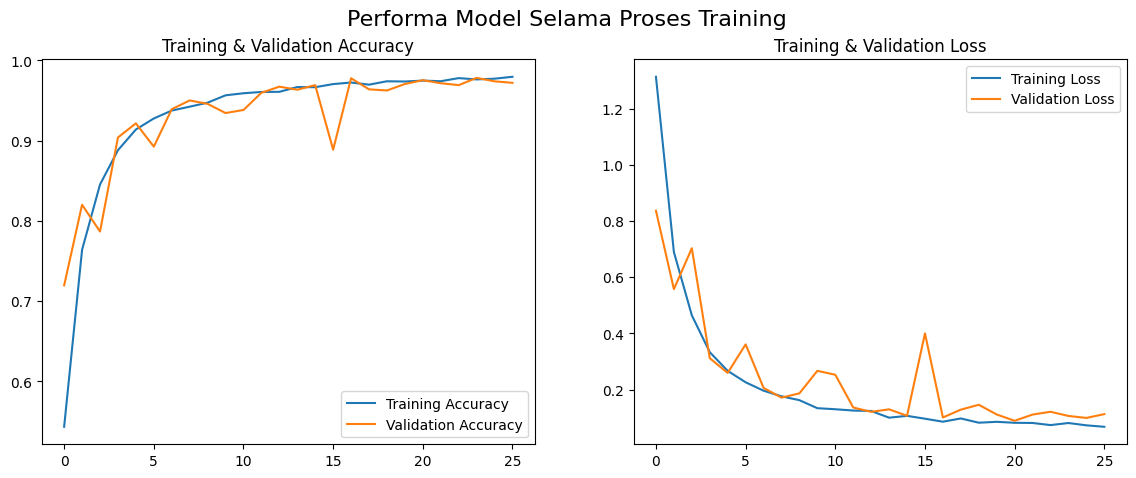

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

plt.suptitle('Performa Model Selama Proses Training', fontsize=16)
plt.show()

### Evaluasi Akurasi Model

Akurasi model pada data uji digunakan untuk menilai generalisasi model terhadap data baru. Target akurasi minimum adalah 85% untuk dapat dikatakan berhasil sesuai kriteria proyek.


In [53]:
# Evaluasi akurasi dan loss di data test
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f'\n🎯 Akurasi Test Set: {test_accuracy * 100:.2f}%')
print(f'📉 Loss Test Set: {test_loss:.4f}')


66/66 ━━━━━━━━━━━━━━━━━━━━ 33s 492ms/step - accuracy: 0.9871 - loss: 0.0532

🎯 Akurasi Test Set: 98.10%
📉 Loss Test Set: 0.0866


### Confusion Matrix

Matriks ini menunjukkan performa klasifikasi model per kelas. Baris mewakili label sebenarnya, dan kolom mewakili prediksi model. Angka diagonal adalah prediksi benar. Matriks ini membantu mengidentifikasi kelas mana yang masih sering salah prediksi.

66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 468ms/step


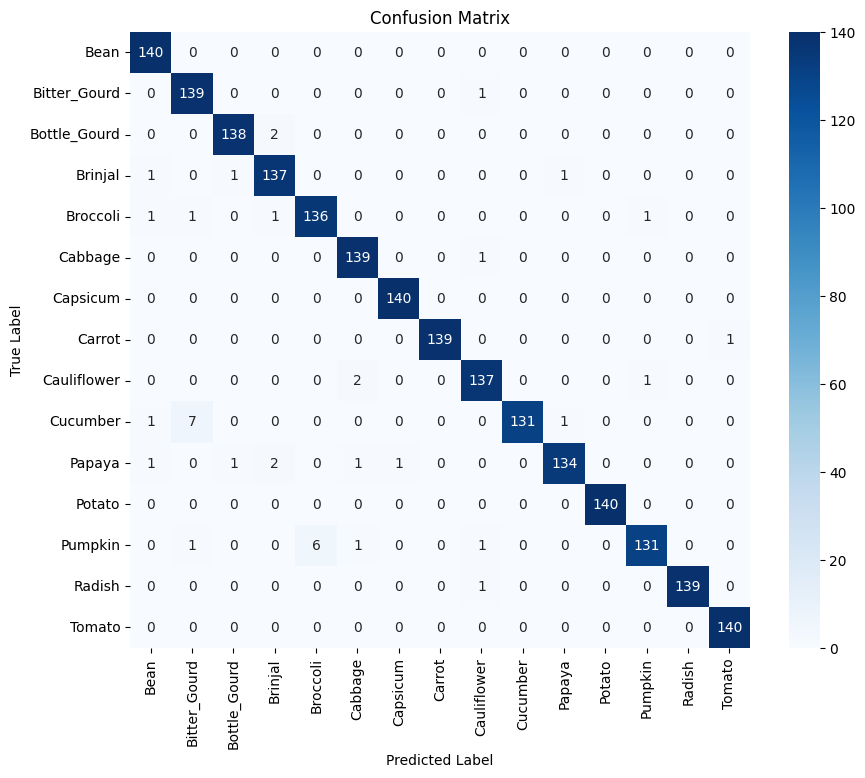

In [54]:
# Prediksi label untuk seluruh test set
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Classification Report

Laporan ini mencakup metrik evaluasi untuk tiap kelas:
- **Precision**: akurasi prediksi positif
- **Recall**: seberapa baik model menangkap semua instance positif
- **F1-Score**: rata-rata harmonis precision dan recall


In [55]:
# Classification report
report = classification_report(y_true, y_pred, target_names=labels)
print("📋 Classification Report:\n")
print(report)

📋 Classification Report:

              precision    recall  f1-score   support

        Bean       0.97      1.00      0.99       140
Bitter_Gourd       0.94      0.99      0.97       140
Bottle_Gourd       0.99      0.99      0.99       140
     Brinjal       0.96      0.98      0.97       140
    Broccoli       0.96      0.97      0.96       140
     Cabbage       0.97      0.99      0.98       140
    Capsicum       0.99      1.00      1.00       140
      Carrot       1.00      0.99      1.00       140
 Cauliflower       0.97      0.98      0.98       140
    Cucumber       1.00      0.94      0.97       140
      Papaya       0.99      0.96      0.97       140
      Potato       1.00      1.00      1.00       140
     Pumpkin       0.98      0.94      0.96       140
      Radish       1.00      0.99      1.00       140
      Tomato       0.99      1.00      1.00       140

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100


### Visualisasi Prediksi Gambar

Beberapa sampel gambar dari test set ditampilkan bersama label sebenarnya dan label prediksi. Ini memberikan gambaran visual seberapa baik model mengenali objek secara nyata.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


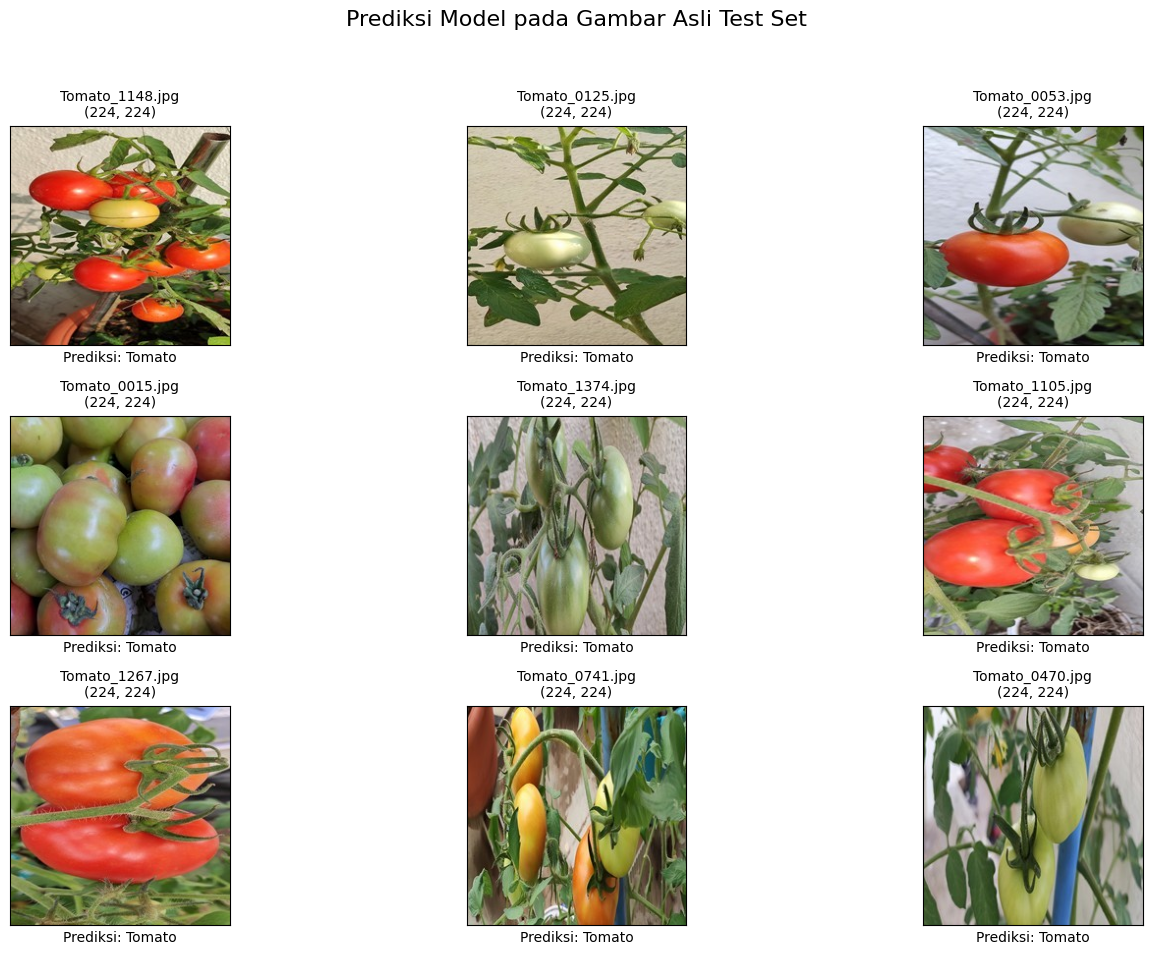

In [56]:
# bisa di ganti dengan nama kelas lain
test_class = 'Tomato'
test_sample_dir = os.path.join(test_dir, test_class)

# Ambil 9 gambar acak dari direktori test
sample_test_images = os.listdir(test_sample_dir)[:9]

plt.figure(figsize=(15, 10))  # ukuran kanvas yang lebih besar

for i, img_name in enumerate(sample_test_images):
    img_path = os.path.join(test_sample_dir, img_name)

    # Load gambar asli untuk ditampilkan
    original_img = image.load_img(img_path)
    width, height = original_img.size  # ambil ukuran asli

    # Load untuk prediksi (resize)
    img_for_model = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img_for_model) / 255.
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)
    predicted_label = class_indices_rev[np.argmax(prediction)]

    # Plot
    plt.subplot(3, 3, i + 1)
    plt.imshow(original_img)
    plt.title(f"{img_name}\n({width}, {height})", fontsize=10)
    plt.xlabel(f"Prediksi: {predicted_label}", fontsize=10)
    plt.xticks([])
    plt.yticks([])

plt.suptitle('Prediksi Model pada Gambar Asli Test Set', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # beri ruang untuk judul utama
plt.show()


## Konversi Model

Model yang telah dilatih akan disimpan ke dalam tiga format:
- **SavedModel**: format default TensorFlow
- **TF-Lite**: untuk perangkat mobile
- **TFJS**: untuk aplikasi berbasis web

Konversi ini dilakukan agar model dapat digunakan lintas platform (web, mobile, cloud). Proses ini penting sebagai bagian dari deployment.


In [57]:
os.makedirs("saved_model", exist_ok=True)
os.makedirs("tflite", exist_ok=True)
os.makedirs("tfjs_model", exist_ok=True)

In [59]:
# 1. Simpan model ke format SavedModel
saved_model_dir = 'saved_model'
model.export('saved_model') # pastikan 'model' adalah objek model yang sudah terlatih

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  132857059634128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132857059637008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132857059637776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132857059634704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132857059636432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132857059638352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132857059632784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132857059638736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132857059639120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132856973820944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132856973821136: T

In [60]:
# 2. Simpan model ke format TF-Lite
tflite_model_path = 'tflite/model.tflite'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan model TFLite
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

### Konversi Model ke Format TensorFlow.js (TFJS)

Agar model dapat digunakan di browser, kita konversi model ke format TFJS. Untuk menghindari warning dan error, kita gunakan model dari format `SavedModel` atau `.keras`, bukan dari `.h5`.

Jika menggunakan Keras 3, direkomendasikan menyimpan dan mengekspor model terlebih dahulu, lalu dikonversi seperti berikut:


In [61]:
# 3. Simpan model ke format TensorFlow.js
# Konversi dari saved_model (direktori)
tfjs.converters.convert_tf_saved_model(
    saved_model_dir='saved_model',
    output_dir='tfjs_model'
)

## Inference (Optional)

In [67]:
# 1. Load model (jika sudah disimpan)
model = load_model('/content/best_model/best_model.h5')  # Pastikan file model.h5 sudah ada

In [68]:
# 2. Load dan preprocess gambar baru
def load_and_prepare_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Sesuai IMG_HEIGHT & IMG_WIDTH
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi seperti saat training
    img_array = np.expand_dims(img_array, axis=0)  # Tambah dimensi batch
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


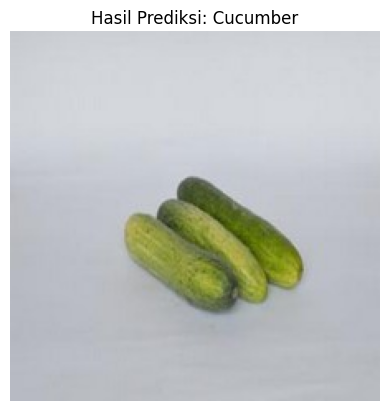

In [73]:
# 3. Predict dan tampilkan hasil
def predict_image(img_path, class_indices):
    img_array = load_and_prepare_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Mapping dari indeks ke nama kelas
    class_labels = dict((v, k) for k, v in class_indices.items())  # Balik dictionary
    label = class_labels[predicted_class]

    # Tampilkan gambar dan hasil
    plt.imshow(image.load_img(img_path))
    plt.title(f"Hasil Prediksi: {label}")
    plt.axis('off')
    plt.show()

# Contoh pemakaian
predict_image('/content/split_dataset/test/Cucumber/Cucumber_0205.jpg', train_generator.class_indices)